In [30]:
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics, tree
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor


In [31]:
data = pd.read_csv("data/train_house_prices.csv");
print data.head(5)
print data.tail(5)
del data['Id']


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [32]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

In [33]:
print data.isnull().values.any() #проверяем, есть ли пустые ячейки
print X.values[0]

True
[60 'RL' 65.0 8450 'Pave' nan 'Reg' 'Lvl' 'AllPub' 'Inside' 'Gtl' 'CollgCr'
 'Norm' 'Norm' '1Fam' '2Story' 7 5 2003 2003 'Gable' 'CompShg' 'VinylSd'
 'VinylSd' 'BrkFace' 196.0 'Gd' 'TA' 'PConc' 'Gd' 'TA' 'No' 'GLQ' 706 'Unf'
 0 150 856 'GasA' 'Ex' 'Y' 'SBrkr' 856 854 0 1710 1 0 2 1 3 1 'Gd' 8 'Typ'
 0 nan 'Attchd' 2003.0 'RFn' 2 548 'TA' 'TA' 'Y' 0 61 0 0 0 0 nan nan nan 0
 2 2008 'WD' 'Normal']


In [34]:
#разбиваем признаки на категориальные и вещественные, чтобы построить адекватную модель
numeric_cols = []
categorial_cols = []

for i in range(0, len(X.columns)):
    
    for j in np.arange(0, len(X.values)):
        if type(X.values[j][i]) is str:
            categorial_cols.append(X.columns[i])
            break
        if type(X.values[j][i]) is int:
            numeric_cols.append(X.columns[i])
            break
        if type(X.values[j][i]) is float:
            numeric_cols.append(X.columns[i])
            break

numeric_cols.remove("Alley")
numeric_cols.remove("FireplaceQu")
numeric_cols.remove("PoolQC")
numeric_cols.remove("Fence")
numeric_cols.remove("MiscFeature")

categorial_cols.append("Alley")
categorial_cols.append("FireplaceQu")
categorial_cols.append("PoolQC")
categorial_cols.append("Fence")
categorial_cols.append("MiscFeature")

In [35]:
print len(categorial_cols)
print len(numeric_cols)
print data.info()


43
36
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      146

In [36]:
#нужно заполнить пустые значения в данных для создания адекватной модели
#в случае вещественных признаков проверим качество двух подходов: заполним пропуски средними значениями и нулями
import math

def calculate_means(numeric_data):#формируем средние значения каждого вещественного признака
    means = np.zeros(numeric_data.shape[1])
    
    for j in range(numeric_data.shape[1]):
        
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
        
    return pd.Series(means, numeric_data.columns)

X_cat = X.drop(numeric_cols, axis = 1).values
X_real_means = X.drop(categorial_cols, axis = 1).values
X_real_zeros = X.drop(categorial_cols, axis = 1).values

numeric_data = X.drop(categorial_cols, axis = 1)
means_cols = calculate_means(numeric_data)
print means_cols


#заполняем наши пропущенные данные: 0, средними и строками 'NA'
def fill_empty_values(real, cat):
    
    for num, X_real_data in enumerate(real):
        
        for i in np.arange(0, len(X_real_data[0])):
            
            for j in np.arange(0, len(X_real_data[0][i])):#X_real_data[0] - это список c 0 вместо пустот 
                if math.isnan(X_real_data[0][i][j]):#X_real_data[1] - это список cо средними вместо пустот 
                    X_real_data[0][i][j] = 0
                    X_real_data[1][i][j] = X_real_data[2][j] #X_real_data[2] - это список средних значений 
    
    for X_cat_data in cat:
        
        for i in np.arange(0, len(X_cat_data)):
            for j in np.arange(0, len(X_cat_data[i])):
                X_cat_data[i][j] = str(X_cat_data[i][j])
                if X_cat_data[i][j] == 'nan':
                    X_cat_data[i][j] = 'NA'
        
fill_empty_values([[X_real_zeros, X_real_means, means_cols]], [X_cat])

X_cat = pd.DataFrame(data = X_cat, columns = categorial_cols)
X_real_zeros = pd.DataFrame(data = X_real_zeros, columns = numeric_cols)
X_real_means = pd.DataFrame(data = X_real_means, columns = numeric_cols)


MSSubClass          56.897260
LotFrontage         70.049958
LotArea          10516.828082
OverallQual          6.099315
OverallCond          5.575342
YearBuilt         1971.267808
YearRemodAdd      1984.865753
MasVnrArea         103.685262
BsmtFinSF1         443.639726
BsmtFinSF2          46.549315
BsmtUnfSF          567.240411
TotalBsmtSF       1057.429452
1stFlrSF          1162.626712
2ndFlrSF           346.992466
LowQualFinSF         5.844521
GrLivArea         1515.463699
BsmtFullBath         0.425342
BsmtHalfBath         0.057534
FullBath             1.565068
HalfBath             0.382877
BedroomAbvGr         2.866438
KitchenAbvGr         1.046575
TotRmsAbvGrd         6.517808
Fireplaces           0.613014
GarageYrBlt       1978.506164
GarageCars           1.767123
GarageArea         472.980137
WoodDeckSF          94.244521
OpenPorchSF         46.660274
EnclosedPorch       21.954110
3SsnPorch            3.409589
ScreenPorch         15.060959
PoolArea             2.758904
MiscVal   

In [37]:
#теперь нужно закодировать категориальные признаки, чтобы учитывать их при обучении модели
from sklearn.feature_extraction import DictVectorizer as DV

#приведем простой пример того, как это происходит
categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)
#первые 2 столбца - национальность, 3 последних - пол

Исходные данные:

  nationality     sex
0    American    male
1    European  female
2       Asian    male
3    European  female

Закодированные данные:

[[ 1.  0.  0.  0.  1.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 0.  0.  1.  1.  0.]]


In [38]:
#теперь применим тот же метод на наших данных
encoder = DV(sparse = False)
X_cat_vect = encoder.fit_transform(X_cat.T.to_dict().values())
print len(X_cat_vect)

1460


In [39]:
#разделим данные на обучающие и тестовые
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size = 0.3, 
                                     random_state = 0)
(X_train_real_means, 
 X_test_real_means) = train_test_split(X_real_means, 
                                      test_size = 0.3, 
                                      random_state = 0)
(X_train_cat_vect,
 X_test_cat_vect) = train_test_split(X_cat_vect, 
                                   test_size = 0.3, 
                                   random_state = 0)

print len(X_train_cat_vect)
print len(X_test_cat_vect)
print len(X_train_real_zeros)

1022
438
1022


In [40]:
#соединим категориальные и вещественные признаки
X_train_zeros_cat = np.hstack((X_train_real_zeros, X_train_cat_vect))
X_train_means_cat = np.hstack((X_train_real_means, X_train_cat_vect))
X_test_zeros_cat = np.hstack((X_test_real_zeros, X_test_cat_vect))
X_test_means_cat = np.hstack((X_test_real_means, X_test_cat_vect))


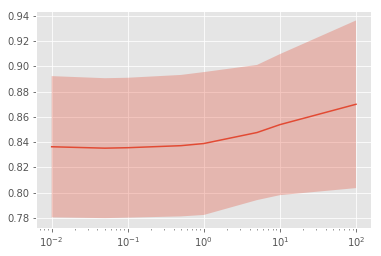

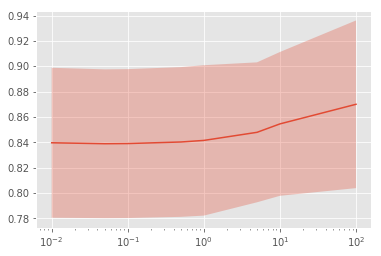

In [37]:
#применим метод линейной регрессии с выбором параметра регуляризации по сетке

#функция построения графиков: потом пригодится для оценки качества алгоритмов
def plot_scores(optimizer):
    scores = [[item[0]['alpha'], 
               item[1], 
               (np.sum( (item[2] - item[1]) ** 2) / (item[2].size - 1) ) ** 0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

# С - это (1 / k), где k - это коэффициент при сумме регуляризации, применяемой при обучении модели для сдерживания роста
# весов при - для предовтвращения переобучения модели. Будем использовать L2 и L1 регуляризации: потом подробно расскажу.
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]} #значения коэффициента
cv = 3 #количество разбиений при обучении на сетке

estimator1 = linear_model.Lasso(max_iter = 10000)

#обучаем первую модель с заполнением нулями
optimizer1 = GridSearchCV(estimator = estimator1, param_grid = param_grid, cv = cv)
optimizer1.fit(X_train_zeros_cat, y_train)
predict1 = optimizer1.predict(X_test_zeros_cat)

#обучаем вторую модель с заполнением с помощью среднего значения
optimizer2 = GridSearchCV(estimator = estimator1, param_grid = param_grid, cv = cv)
optimizer2.fit(X_train_means_cat, y_train)
predict2 = optimizer2.predict(X_test_means_cat)

plot_scores(optimizer1)
plot_scores(optimizer2)


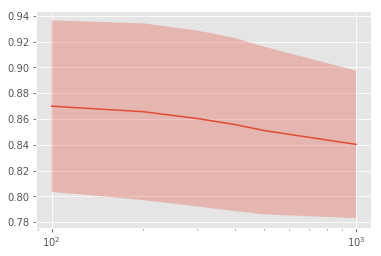

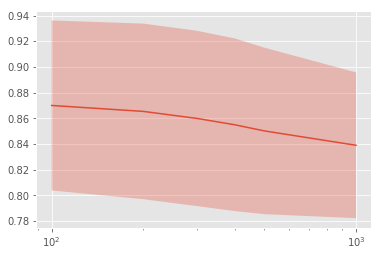

In [58]:
#видим, что при данных значениях параметра альфа точность предсказаний нашей модели достигает максимума при alpha=100
#проверим, что будет просходить при больших aplha
param_grid = {'alpha': [100, 200, 300, 400, 500, 1000]} #значения коэффициента
cv = 3 #количество разбиений при обучении на сетке

estimator2 = linear_model.Lasso(max_iter = 10000)

#обучаем первую модель с заполнением нулями
optimizer3 = GridSearchCV(estimator = estimator2, param_grid = param_grid, cv = cv)
optimizer3.fit(X_train_zeros_cat, y_train)
predict3 = optimizer3.predict(X_test_zeros_cat)

#обучаем вторую модель с заполнением с помощью среднего значения
optimizer4 = GridSearchCV(estimator = estimator2, param_grid = param_grid, cv = cv)
optimizer4.fit(X_train_means_cat, y_train)
predict4 = optimizer4.predict(X_test_means_cat)

plot_scores(optimizer3)
plot_scores(optimizer4)

In [20]:
#видим, что качество стало падать с ростом коэффициента alpha -> берем alpha = 100
#проверим нашу модель на тестовых данных -> обработаем их, предскажем стоимость и отправим на проверку
data = pd.read_csv("data/test_house_prices.csv");
print data.head(5)
print data.tail(5)
del data["Id"]

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN   

In [21]:
print data.isnull().values.any() #проверяем, есть ли пустые ячейки
X = data


True


In [22]:
print data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

In [23]:
#разбиваем признаки на категориальные и вещественные, чтобы построить адекватную модель
numeric_cols = []
categorial_cols = []

for i in range(0, len(X.columns)):
    
    for j in np.arange(0, len(X.values)):
        if type(X.values[j][i]) is str:
            categorial_cols.append(X.columns[i])
            break
        if type(X.values[j][i]) is int:
            numeric_cols.append(X.columns[i])
            break
        if type(X.values[j][i]) is float:
            numeric_cols.append(X.columns[i])
            print X.columns[i]
            break

numeric_cols.remove("Alley")
numeric_cols.remove("FireplaceQu")
numeric_cols.remove("PoolQC")
numeric_cols.remove("MiscFeature")

categorial_cols.append("Alley")
categorial_cols.append("FireplaceQu")
categorial_cols.append("PoolQC")
categorial_cols.append("MiscFeature")

LotFrontage
Alley
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
FireplaceQu
GarageYrBlt
GarageCars
GarageArea
PoolQC
MiscFeature


In [24]:
print len(categorial_cols)
print len(numeric_cols)

43
36


In [25]:
X_cat = X.drop(numeric_cols, axis = 1).values
X_real_means = X.drop(categorial_cols, axis = 1).values
X_real_zeros = X.drop(categorial_cols, axis = 1).values

numeric_data = X.drop(categorial_cols, axis = 1)
means_cols = calculate_means(numeric_data)
print means_cols

fill_empty_values([[X_real_zeros, X_real_means, means_cols]], [X_cat])

X_cat = pd.DataFrame(data = X_cat, columns = categorial_cols)
X_real_zeros = pd.DataFrame(data = X_real_zeros, columns = numeric_cols)
X_real_means = pd.DataFrame(data = X_real_means, columns = numeric_cols)


MSSubClass         57.378341
LotFrontage        68.580357
LotArea          9819.161069
OverallQual         6.078821
OverallCond         5.553804
YearBuilt        1971.357779
YearRemodAdd     1983.662783
MasVnrArea        100.709141
BsmtFinSF1        439.203704
BsmtFinSF2         52.619342
BsmtUnfSF         554.294925
TotalBsmtSF      1046.117970
1stFlrSF         1156.534613
2ndFlrSF          325.967786
LowQualFinSF        3.543523
GrLivArea        1486.045922
BsmtFullBath        0.434454
BsmtHalfBath        0.065202
FullBath            1.570939
HalfBath            0.377656
BedroomAbvGr        2.854010
KitchenAbvGr        1.042495
TotRmsAbvGrd        6.385195
Fireplaces          0.581220
GarageYrBlt      1977.721217
GarageCars          1.766118
GarageArea        472.768861
WoodDeckSF         93.174777
OpenPorchSF        48.313914
EnclosedPorch      24.243317
3SsnPorch           1.794380
ScreenPorch        17.064428
PoolArea            1.744345
MiscVal            58.167923
MoSold        

In [26]:
#теперь применим тот же метод векторизации категориальных признаков на тестовых данных
X_cat_vect = encoder.transform(X_cat.T.to_dict().values())
print len(X_cat_vect)

1459


In [27]:
X_zeros_cat = np.hstack((X_real_zeros, X_cat_vect))
X_means_cat = np.hstack((X_real_means, X_cat_vect))

print len(X_zeros_cat)
print len(X_means_cat)

1459
1459


In [68]:
predict_zeros = optimizer2.best_estimator_.predict(X_zeros_cat)
predict_means = optimizer2.best_estimator_.predict(X_means_cat)

print predict_zeros[:2]
print predict_means[:2]

print data[:2]

[ 120160.93737218  163221.10647821]
[ 120160.93737218  163221.10647821]
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          20       RH         80.0    11622   Pave   NaN      Reg   
1          20       RL         81.0    14267   Pave   NaN      IR1   

  LandContour Utilities LotConfig      ...       ScreenPorch PoolArea PoolQC  \
0         Lvl    AllPub    Inside      ...               120        0    NaN   
1         Lvl    AllPub    Corner      ...                 0        0    NaN   

   Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0  MnPrv         NaN       0       6    2010        WD         Normal  
1    NaN        Gar2   12500       6    2010        WD         Normal  

[2 rows x 79 columns]


In [41]:
def write_answer(predict, num):
    file_name = 'house_prices' + str(num) + '.csv'
    f = open(file_name,'w')
    f.write('Id,SalePrice\n')
    i = 1461
    for label in predict_means:
        s = str(i)+ ',' + str(label) + '\n'
        f.write(s)
        i += 1
    f.close()

In [13]:
print optimizer1.best_estimator_.coef_

[ -1.16856093e+02   3.17342554e+01   5.35963888e-01   8.15371155e+03
   5.48132925e+03   3.38339483e+02   7.87617884e+01   2.96472982e+01
   2.28448388e+01   1.45226532e+01   1.02212183e+01   7.21333933e+00
   4.55281742e+01   5.12559215e+01   3.15854630e+01   6.72058957e+00
   1.82404841e+03  -0.00000000e+00   2.44354768e+03   0.00000000e+00
  -3.91490294e+03  -1.27124500e+04   1.72436303e+03   2.51521276e+03
  -4.91574061e+00   1.60539495e+03   2.48670798e+01   1.70076532e+01
   1.44212101e+01   3.83871709e+00   1.36190058e+01   2.44462815e+01
   4.40596810e+01  -1.54161676e-01  -3.14420274e+02  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   4.86665658e+03   0.00000000e+00
  -3.12824058e+05  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.48142607e+04   0.00000000e+00  -9.00639911e+03   0.00000000e+00
  -6.22400040e+03  -0.00000000e+00  -2.43966866e+03   0.00000000e+00
   0.00000000e+00   5.99989123e+02

In [12]:
#попробуем улучшить качество с помощью градиентного бустинга (сначала написанного мной)
#смысл: каждый новый алгоритм исправляет ошибки старой модели
def gbm_predict(X, algorithms, coefs):#функция предсказания ответа (суммирует ответы каждого алгоритма )
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(algorithms, coefs)]) for x in X]


def gboost(n_algos, X_train, y_train):#функция построения модели из простых алгоритмов
    
    algos = list() #список алгоритмов
    coefs = list() #список коэффициентов перед базовыми алгоритмами (вес)
    answers = y_train #для подсчета градиента
    
    for i in np.arange(0, n_algos):
        regressor = linear_model.Lasso(alpha = 100)
        regressor.fit(X_train, answers)
        algos.append(regressor)
        coefs.append( 0.9 / (1.0 + i) )
        predict = gbm_predict(X_train, algos, coefs)
        answers = (y_train - predict)
        
    
    return [algos, coefs]


In [14]:
#обучим набор композиций с разными параметрами - видим, что с увеличением числа алгоритмов типа Lasso растет ошибка, где Lasso - это 
#простая регрессионная модель,которая подбирает параметры методом градиентного спуска, дополнительно имеет сумму модулей 
# полученных коэффициентов для сдерживания модели от переобучения при подсчете ошибки на каждой итерации градиентного
#спуска. Заметив тенденцию роста ошибки, опыт остановил - интерпретатор выдал ошибку (не пугайтесь)
#Хочу заметить, что градиентный бустинг, написанный мной, работает исключительно с первыми производными - будем улучшать
models_zeros = [] #список моделей с разными параметрами
models_means = [] #список моделей с разными параметрами
n_algos = [20, 35, 50, 65, 80, 100]

for n in n_algos:
    model1 = gboost(n, X_train_means_cat, y_train)#модель со средними вместо пустых значений
    model2 = gboost(n, X_train_zeros_cat, y_train)#модель с нулями вместо пустых значений
    models_zeros.append(model2)
    models_means.append(model1)
    predict1 = gbm_predict(X_test_means_cat, model1[0], model1[1])
    predict2 = gbm_predict(X_test_zeros_cat, model2[0], model2[1])
    print 'n - ' + str(n) + '\n'
    print (metrics.mean_squared_error(y_test, predict1)) ** 0.5
    print (metrics.mean_squared_error(y_test, predict2)) ** 0.5
    print '\n'
%time   

n - 20

42526.9286029
41873.3976012


n - 35

42581.3907526
41924.3033054


n - 50

42606.3905545
41947.8351179


n - 65

42620.838802
41961.4818693




KeyboardInterrupt: 

In [28]:
predict_zeros = gbm_predict(X_zeros_cat, models_zeros[0][0], models_zeros[0][1])
predict_means = gbm_predict(X_means_cat, models_means[0][0], models_means[0][1])

In [29]:
write_answer(predict_zeros, '_zeros')
write_answer(predict_means, '_means')

In [44]:
#прежде чем самим улучшить рукописный градиентный бустинг посмотрим на качество реализации бустинга из sklearn
gb_models = []
for n in n_algos:
    gb_model = GradientBoostingRegressor(n_estimators=n)
    gb_model.fit(X_train_means_cat, y_train)
    gb_models.append(gb_model)
    predict = gb_model.predict(X_test_means_cat)
    print 'n - ' + str(n) + '\n'
    print (metrics.mean_squared_error(y_test, predict)) ** 0.5
    print '\n'

n - 20

35240.0207046


n - 35

31272.1506423


n - 50

32013.0315852


n - 65

30830.2964022


n - 80

30696.711738


n - 100

30876.3205929




In [45]:
predict_result = gb_models[4].predict(X_means_cat)
write_answer(predict_result, '_means1')